In [17]:
# Loading libraries
#####################################################################

# Standard libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import six
import os

# Datasets
from sklearn import datasets

# Models
from sklearn.cross_decomposition import PLSRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

# Extra libraries
from IPython.display import display 
from sklearn.utils import resample
from itertools import cycle
from scipy import interp
from pickle import dump
import joblib

#####################################################################

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
pd.options.display.max_columns = 999


# Properties, models and normalization methods used
#####################################################################

properties = [
    'pH',
    'OM',
    'Ca',
    'Mg',
    'K',
#     'Na'
]

models = [
    'LR',
    'SVR',
    'LASSO',
    'PLSR2',
    'PLSR6',
    'RF'
]

model_funct = {
    'LR': LinearRegression(),
    'SVR': SVR(kernel='linear'),
    'LASSO': LassoCV(
        cv=5, random_state=0, max_iter = 30000,
        verbose = 0, n_jobs = -1 # verbose = 10
    ),
    'PLSR2': PLSRegression(n_components=2),
    'PLSR6': PLSRegression(n_components=6),
    'RF': RandomForestRegressor(
            bootstrap=True,
            max_depth=4,
            max_features='auto',
            min_samples_leaf=2,
            min_samples_split=5,
            n_estimators=72,
            verbose = 0
        )
}

scalers = [
    'wo_norm',
    'minmax',
    'standard'
]

satellites = [
#     'landsat_simulated',
#     'landsat_simulated_indices',
#     'sentinel2_simulated',
#     'sentinel2_simulated_indices',
#     'sentinel2',
#     'sentinel2_indices',
    'sentinel2_veggi',
    'sentinel2_veggi_indices'
#     'desis_simulated',
#     'vis_nir'
]

satellites_with_indices = [
    'landsat_simulated_indices',
    'sentinel2_simulated_indices',
    'sentinel2_indices'
]

transformations = {
    'scE_d1_d2_': ['scE_', 'd1_', 'd2_'],
    'scE_d1_d2_fft_': ['scE_', 'd1_', 'd2_', 'fft_'],
    'scE_d1_d2_fft_cr_': ['scE_', 'd1_', 'd2_', 'fft_', 'cr_']
}

indices_ = [
    'SIPI', 'ARVI', 'NDSI', 'NDWI',
    'BSI', 'NBR', 'GCI', 'MSI', 'NDMI',
    'SAVI', 'AVI', 'EVI', 'GNDVI', 'NDVI',
    'NDGI'
]

In [24]:
#####################################################################


# Creating dataframe to save the metrics results
#####################################################################

def create_band_metrics():
    band_metrics = [
        'Satellite', 'Scaler', 'Features', 'Property' ,'Model', 
        'CC Train All', 'CC Test All',
        'MSE Train All', 'MSE CV All', 'MSE Test All',
        'R2 Train All', 'R2 CV All', 'R2 Test All',
        'EV Train All', 'EV CV All', 'EV Test All'
    ]

    metrics_df = pd.DataFrame(columns=band_metrics)
    return metrics_df


def check_path(path):
    files = path.split('/')
    tmp_path = ''
    
    for file in files:
        tmp_path += f"{file}/"
        if not os.path.exists(tmp_path):
            os.mkdir(tmp_path)
#         else:
#             print(f'File: **{file}** exists')


def get_data(satellite, scaler, property_, transformation):
    
    temp_all_data = pd.read_csv(
        f'../data/models/input/{satellite}/{scaler}/' +
        f"All_{scaler}_d1d2_fft_feature_{property_}_.csv",
        sep = ';',
        decimal = '.'
    )
    temp_cols = temp_all_data.columns[:4].tolist()

    if satellite in satellites_with_indices:
        temp_cols.extend(indices_)

    temp_cols.extend(
        [
            i for i in temp_all_data.columns[4:].tolist() 
            for j in transformations[transformation] if i.startswith(j)
        ]
    )

    temp_all_data = temp_all_data[temp_cols].copy()
    return temp_all_data
    
    
    
def transform_data(temp_all_data, satellite, property_):
    
    non_spectral_cols = list(temp_all_data.columns[:4])

    if satellite in satellites_with_indices:
        non_spectral_cols.extend(indices_)

    non_spectral_cols.remove(f"sc_{property_}")

    temp_all_data.drop(non_spectral_cols, axis=1, inplace=True)
    temp_all_data.rename(columns={f"sc_{property_}":'class'}, inplace=True)     
    
    return temp_all_data


def calculate_metrics(metrics_df, y_train, y_prd_train_, satellite,
                      scaler, transformation, property_, model_text, scores):
 
    corr_train = round(np.corrcoef(y_train, y_prd_train_)[0, 1], 3)
    corr_test = round(np.corrcoef(y_test, y_prd_test_)[0, 1], 3)

    current_property_metrics = [
        satellite,
        scaler,
        transformation,
        property_,
        model_text,

        corr_train,
        corr_test,

        mean_squared_error(y_train, y_prd_train).round(3),
        np.mean(scores['test_mean_squared_error']).round(3),
        mean_squared_error(y_test, y_prd_test).round(3),

        r2_score(y_train, y_prd_train).round(3),
        np.mean(scores['test_r2']).round(3),
        r2_score(y_test, y_prd_test).round(3),

        explained_variance_score(y_train, y_prd_train).round(3),
        np.mean(scores['test_explained_variance']).round(3),
        explained_variance_score(y_test, y_prd_test).round(3)
    ]

    metrics_df.loc[metrics_df.shape[0]] = current_property_metrics

    
def save_train_test_data(X_train, y_train, y_prd_train_,
                         X_test, y_test, y_prd_test_, satellite,
                         scaler, transformation, property_):
    train_data = X_train.copy()
    train_data['y_train'] = y_train
    train_data['y_prd_train_'] = y_prd_train_

    test_data = X_test.copy()
    test_data['y_test'] = y_test
    test_data['y_prd_test_'] = y_prd_test_

    
    find_path = (
        f'../data/models/predictions/{satellite}/{scaler}/' +
        f"/{transformation}/{property_}"
    )
    check_path(find_path)

    train_data.to_csv(
        f"{find_path}/train_prediction.csv",
        sep=';', decimal='.', index=False
    )
    
    test_data.to_csv(
        f"{find_path}/test_prediction.csv",
        sep=';', decimal='.', index=False
    )
    return find_path

    
def save_model(regressor, satellite, scaler, property_, transformation):
    model_path = (
        f'../models/{satellite}/{scaler}/' +
        f"/{property_}/{transformation}"
    )

    check_path(model_path)
    joblib.dump(
        regressor,
        f"{model_path}/{model_text}_model.joblib"
    ) 
    
    
def save_metrics(metrics_df, satellite, scaler, property_, transformation, find_path):
    find_route = (
        f"../reports/metrics/{satellite}/" +
        f"{scaler}/{property_}"
    )
    check_path(find_route)
    
    metrics_df.to_csv(
        f"{find_path}/metrics.csv", sep=';', decimal='.', index=False
    )
    metrics_df.to_csv(
        f"{find_route}/{transformation}_metrics.csv",
        sep=';', decimal='.', index=False
    )
    
#####################################################################

In [25]:
# Dividing data
#####################################################################

for satellite in satellites:
    print(f"satellite: {satellite}")

    for scaler in scalers:
        print(f"scaler: {scaler}")

        for transformation in transformations:
#             print(f"transformation: {transformation}")

            for property_ in properties:
#                 print(f"property_: {property_}")

                metrics_df = create_band_metrics()
                temp_all_data = get_data(satellite, scaler, property_, transformation)
                temp_all_data = transform_data(temp_all_data, satellite, property_)

                # Dividing train and test data
                ##########################################################################
                if satellite in ['sentinel2_veggi', 'sentinel2_veggi_indices']:
                    X_train, y_train = temp_all_data.iloc[:, 1:], temp_all_data['class']
                    X_test, y_test = temp_all_data.iloc[:, 1:], temp_all_data['class']
                else:
                    X_train, X_test, y_train, y_test = train_test_split(
                        temp_all_data.iloc[:, 1:], 
                        temp_all_data['class'],
                        test_size=0.1
                    )

                # Training models
                #####################################################################

                for model_text in models:
                    print(f"model: {model_text}")

                    model = model_funct[model_text]

                    scoring = {
                        'mean_squared_error': make_scorer(mean_squared_error),
                        'r2': 'r2',
                        'explained_variance': 'explained_variance'
                    }

                    regressor = model.fit(X_train, y_train)
                    scores = cross_validate(model, X_test, y_test, scoring=scoring) 

                    y_prd_train = regressor.predict(X_train)
                    y_prd_test = regressor.predict(X_test)

                    y_prd_train_ = (
                        y_prd_train if model_text not in ['PLSR2', 'PLSR6']
                        else y_prd_train[:, 0]
                    )
                    y_prd_test_ = (
                        y_prd_test if model_text not in ['PLSR2', 'PLSR6']
                        else y_prd_test[:, 0]
                    )

                    save_model(regressor, satellite, scaler, property_, transformation) 

                    # Save Train/Test data
                    #####################################################################
                    
                    find_path = save_train_test_data(
                        X_train, y_train, y_prd_train_,
                        X_test, y_test, y_prd_test_, satellite,
                        scaler, transformation, property_
                    )

                    calculate_metrics(
                        metrics_df, y_train, y_prd_train_,
                        satellite, scaler, transformation,
                        property_, model_text, scores
                    )

#                     display(metrics_df.loc[metrics_df.shape[0]-1])

                save_metrics(
                    metrics_df, satellite, scaler,
                    property_, transformation, find_path
                )

#             display(metrics_df)


satellite: sentinel2_veggi
scaler: wo_norm
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019678681995642933, tolerance: 0.012296379272727274
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06364994640451016, tolerance: 0.012341647272727274
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0303257152042562, tolerance: 0.012296379272727274
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\skl

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.673317371822122, tolerance: 1.3498639810909092
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.528705303449897, tolerance: 1.6350822798214288
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9643878343831602, tolerance: 1.5676976370909093
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022672361508124794, tolerance: 0.0012488170909090907
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005141078251840625, tolerance: 0.001291948
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002578426041489834, tolerance: 0.0008651938181818182
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklear

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017304355408609418, tolerance: 6.086109090909091e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025259466712096446, tolerance: 5.961927272727274e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004031600545931213, tolerance: 6.086109090909091e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-p

model: PLSR2
model: PLSR6
model: RF
scaler: minmax
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016662393329647252, tolerance: 0.00012420630797773652
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001622115766802823, tolerance: 0.00012420630797773652
  model = cd_fast.enet_coordinate_descent_gram(


model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014924306563792733, tolerance: 0.0006533109965576177
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017030932464163762, tolerance: 0.0005549864879472492
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010108417508272183, tolerance: 0.0005549864879472492
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-pac

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019512820009581766, tolerance: 0.00018810619223787956
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002568019653841347, tolerance: 0.00018734911252442124
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034596438421541365, tolerance: 0.00018741623643845875
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\sit

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008562022691642746, tolerance: 0.0006705596869063914
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016261952922667078, tolerance: 0.0005535894919155935
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011825918718821882, tolerance: 0.0006705596869063914
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-pac

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025608809264365817, tolerance: 0.00018192662008465287
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024852937881214565, tolerance: 0.00018315009843748704
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008176863463735806, tolerance: 0.00018192662008465287
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\sit

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019520871458766909, tolerance: 0.00011993840445269013
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024687926139932426, tolerance: 0.00011697365491651206
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000694130927424097, tolerance: 0.00011993840445269013
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site

model: PLSR2
model: PLSR6
model: RF
scaler: standard
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008026134304927268, tolerance: 0.005793333650680421
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006138262710383202, tolerance: 0.005793333650680421
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059893061206821585, tolerance: 0.005793333650680421
  model = cd_fast.enet_coordinate_descent(


model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01277509187926995, tolerance: 0.00577827964915109
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020447777781122056, tolerance: 0.005755023539136758
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01833229400229186, tolerance: 0.004615264397724073
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\skl

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00819109785809502, tolerance: 0.006009004356453624
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02696369978597346, tolerance: 0.0056994817062187095
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012303322867936117, tolerance: 0.006009004356453624
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\s

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006587012481269028, tolerance: 0.003934327865542127
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01141779180611735, tolerance: 0.005874922948378316
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009379623343619414, tolerance: 0.003934327865542127
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\s

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008813898667987985, tolerance: 0.006010420474805842
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0165605846716943, tolerance: 0.006010420474805842
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01807045019952369, tolerance: 0.006010420474805842
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\skl

model: PLSR2
model: PLSR6
model: RF
satellite: sentinel2_veggi_indices
scaler: wo_norm
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06364994640451016, tolerance: 0.012341647272727274
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019678681995642933, tolerance: 0.012296379272727274
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0303257152042562, tolerance: 0.012296379272727274
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\skl

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.673317371822122, tolerance: 1.3498639810909092
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.528705303449897, tolerance: 1.6350822798214288
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9643878343831602, tolerance: 1.5676976370909093
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022672361508124794, tolerance: 0.0012488170909090907
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005141078251840625, tolerance: 0.001291948
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002578426041489834, tolerance: 0.0008651938181818182
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklear

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017304355408609418, tolerance: 6.086109090909091e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025259466712096446, tolerance: 5.961927272727274e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002326772705555924, tolerance: 3.305553571428571e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-p

model: PLSR2
model: PLSR6
model: RF
scaler: minmax
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016662393329647252, tolerance: 0.00012420630797773652
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001622115766802823, tolerance: 0.00012420630797773652
  model = cd_fast.enet_coordinate_descent_gram(


model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014924306563792733, tolerance: 0.0006533109965576177
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017030932464163762, tolerance: 0.0005549864879472492
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010108417508272183, tolerance: 0.0005549864879472492
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-pac

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002568019653841347, tolerance: 0.00018734911252442124
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019512820009581766, tolerance: 0.00018810619223787956
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034596438421541365, tolerance: 0.00018741623643845875
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\sit

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008562022691642746, tolerance: 0.0006705596869063914
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016261952922667078, tolerance: 0.0005535894919155935
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001136603511889156, tolerance: 0.0006429247320852731
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-pack

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025608809264365817, tolerance: 0.00018192662008465287
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024852937881214565, tolerance: 0.00018315009843748704
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008176863463735806, tolerance: 0.00018192662008465287
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\sit

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019520871458766909, tolerance: 0.00011993840445269013
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000694130927424097, tolerance: 0.00011993840445269013
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024687926139932426, tolerance: 0.00011697365491651206
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site

model: PLSR2
model: PLSR6
model: RF
scaler: standard
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO
model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008026134304927268, tolerance: 0.005793333650680421
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006138262710383202, tolerance: 0.005793333650680421
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059893061206821585, tolerance: 0.005793333650680421
  model = cd_fast.enet_coordinate_descent(


model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01277509187926995, tolerance: 0.00577827964915109
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020447777781122056, tolerance: 0.005755023539136758
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01833229400229186, tolerance: 0.004615264397724073
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\skl

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00819109785809502, tolerance: 0.006009004356453624
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02696369978597346, tolerance: 0.0056994817062187095
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012303322867936117, tolerance: 0.006009004356453624
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\s

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006587012481269028, tolerance: 0.003934327865542127
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01141779180611735, tolerance: 0.005874922948378316
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00687299603349345, tolerance: 0.005678792169428544
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sk

model: PLSR2
model: PLSR6
model: RF
model: LR
model: SVR
model: LASSO


C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008813898667987985, tolerance: 0.006010420474805842
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0165605846716943, tolerance: 0.006010420474805842
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01807045019952369, tolerance: 0.006010420474805842
  model = cd_fast.enet_coordinate_descent(
C:\Users\camil\miniconda3\envs\Tesis\lib\site-packages\skl

model: PLSR2
model: PLSR6
model: RF


### Tuning models

In [3]:
satellites

['landsat_simulated_indices',
 'sentinel2_simulated_indices',
 'sentinel2',
 'sentinel2_indices']

In [4]:
scalers

['wo_norm', 'minmax', 'standard']

In [5]:
properties

['pH', 'OM', 'Ca', 'Mg', 'K', 'Na']

In [6]:
transformations

{'scE_d1_d2_': ['scE_', 'd1_', 'd2_'],
 'scE_d1_d2_fft_': ['scE_', 'd1_', 'd2_', 'fft_'],
 'scE_d1_d2_fft_cr_': ['scE_', 'd1_', 'd2_', 'fft_', 'cr_']}

In [8]:
temp_all_data = get_data('sentinel2', 'minmax', 'pH', 'scE_d1_d2_')
temp_all_data = transform_data(temp_all_data, 'sentinel2','pH')


# Dividing train and test data
##########################################################################

X_train, X_test, y_train, y_test = train_test_split(
    temp_all_data.iloc[:, 1:], 
    temp_all_data['class'],
    test_size=0.3
)

In [9]:
X_train.head()

scE_442.3  scE_492.1  scE_559.0  scE_665.0  scE_703.8  scE_739.1  \
47    0.000000   0.098048   0.247835   0.160674   0.235900   0.576820   
276   0.100250   0.141264   0.237554   0.180899   0.240376   0.507014   
49    0.165557   0.235595   0.362013   0.410674   0.428380   0.424516   
368   0.034110   0.098048   0.189935   0.133146   0.167860   0.369071   
48    0.813644   0.332249   0.325216   0.352247   0.457028   0.493988   

     scE_779.7  scE_833.0  scE_864.0  scE_943.2  scE_1610.4  scE_2202.4  \
47    0.664828   0.708122   0.614973   0.502518    0.358011    0.262974   
276   0.561275   0.539199   0.545187   0.551285    0.270467    0.187839   
49    0.439338   0.402143   0.440642   0.442884    0.662794    0.647947   
368   0.517157   0.509870   0.439037   0.495892    0.226155    0.138652   
48    0.484375   0.309927   0.477273   0.833024    0.379897    0.544152   

     d1_442.3  d1_492.1  d1_559.0  d1_665.0  d1_703.8  d1_739.1  d1_779.7  \
47   0.644220  0.720261  0.290579  0.477788  0.616864  0.549944  0.799751   
276  0.586610  0.573856  0.353008  0.454216  0.508876  0.405163  0.691317   
49   0.604515  0.609150  0.556186  0.464189  0.179980  0.235690  0.654757   
368  0.612301  0.580392  0.356413  0.384406  0.385108  0.707071  0.707935   
48   0.079019  0.248366  0.515323  0.616500  0.250986  0.167228  0.457831   

     d1_833.0  d1_864.0  d1_943.2  d1_1610.4  d2_442.3  d2_492.1  d2_559.0  \
47   0.159897  0.296740  0.400474   0.391956  0.459872  0.203856  0.532459   
276  0.304404  0.463469  0.266719   0.494479  0.482317  0.444211  0.497061   
49   0.345019  0.456725  0.756714   0.286278  0.473322  0.585058  0.455226   
368  0.179136  0.533908  0.278568   0.523659  0.460688  0.439122  0.437134   
48   0.543395  0.956913  0.093470   0.900631  0.870815  1.000000  0.594248   

     d2_665.0  d2_703.8  d2_739.1  d2_779.7  d2_833.0  d2_864.0  d2_943.2  
47   0.632914  0.375212  0.695819  0.175006  0.684448  0.682062  0.596734  
276  0.533023  0.444219  0.665447  0.306006  0.612782  0.510399  0.736170  
49   0.186829  0.790229  0.701979  0.345103  0.568141  0.591562  0.276320  
368  0.440495  0.757400  0.561669  0.221419  0.773150  0.448345  0.735467  
48   0.182306  0.662965  0.571432  0.542936  0.593749  0.036447  1.000000

In [10]:
y_train.head()

47     0.184758
276    0.919169
49     0.150115
368    0.189376
48     0.131640
Name: class, dtype: float64

In [11]:
rf_model_test = RandomForestRegressor(
    bootstrap=True,
    max_depth=4,
    max_features='auto',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=72
)
rf_model_test.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=72)

In [12]:
rf_model_test = RandomForestRegressor(n_estimators=72, min_samples_split=2, min_samples_leaf=2, max_features='auto', max_depth=4, bootstrap=True)
rf_model_test.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, min_samples_leaf=2, n_estimators=72)

In [13]:
scoring = {
    'mean_squared_error': make_scorer(mean_squared_error),
    'r2': 'r2',
    'explained_variance': 'explained_variance'
}


scores = cross_validate(rf_model_test, X_test, y_test, scoring=scoring, cv=10) 

In [14]:
print(rf_model_test.score(X_train, y_train))
print(rf_model_test.score(X_test, y_test))
print(np.mean(scores['test_r2']))
print(np.std(scores['test_r2']))
print(scores['test_r2'])

0.5258982420010825
0.3261321848425811
0.22169505333065506
0.2578742267029084
[ 0.0564878   0.31817575  0.26167119  0.32834284  0.2866046   0.3892278
 -0.47382198  0.38069706  0.1790046   0.49056088]


### Feature importance

In [70]:
len(X_train.columns)

33

Feature ranking:


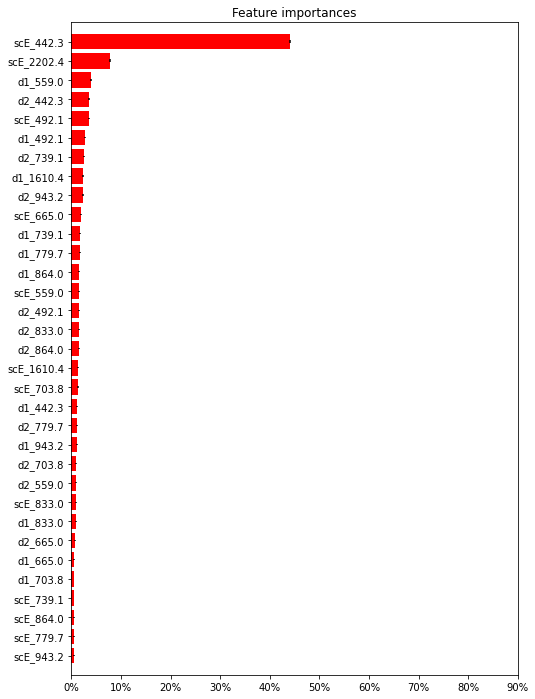

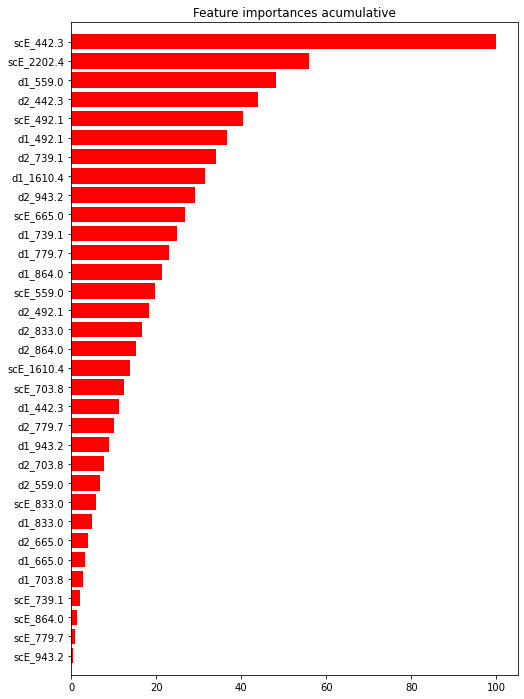

In [20]:
importances = rf_model_test.feature_importances_
std = np.std(
    [
        tree.feature_importances_ for tree in rf_model_test.estimators_
    ],
    axis=0
)
indices = np.argsort(importances)

# Print the feature ranking
print("Feature ranking:")

# for f in range(X_train.shape[1]):
#     print("%d. feature %s (%f) (%s) %%" % (f + 1, X_train.columns[indices[f]], importances[indices[f]], round(importances[indices[f]] * 100, 2)))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(8, 12))
plt.title("Feature importances")
plt.barh(
    range(X_train.shape[1]),
    [round(x, 2) for x in (importances[indices]*100)],
    color="r",
    yerr=std[indices],
    align="center"
)
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xticks(range(0, 100, 10), [f"{i}%" for i in range(0, 100, 10)])
plt.ylim([-1, X_train.shape[1]])
plt.show()

importances_ = importances[indices].copy()
for i in range(1, len(indices)):
    importances_[i] += importances_[i-1]
importances_

plt.figure(figsize=(8, 12))
plt.title("Feature importances acumulative")
plt.barh(
    range(X_train.shape[1]),
    [round(x, 2) for x in (importances_*100)],
    color="r",
#     yerr=std[indices],
    align="center"
)
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
# plt.xticks(range(0, 100, 10), [f"{i}%" for i in range(0, 100, 10)])
plt.ylim([-1, X_train.shape[1]])
plt.show()

### Grid search

In [62]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
# [int(x) for x in np.linspace(10, 160, 20)]

In [65]:
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(10, 160, 20)],
    'max_features': ['auto'],
    'max_depth': [2, 8, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}
# param_grid

In [66]:
rf_Grid = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=10,
    verbose=2,
    n_jobs=-1
)

In [67]:
rf_Grid.fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [2, 8, 4],
                         'max_features': ['auto'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [10, 17, 25, 33, 41, 49, 57, 65, 73,
                                          81, 88, 96, 104, 112, 120, 128, 136,
                                          144, 152, 160]},
             verbose=2)

In [68]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 112}

In [69]:
print(rf_Grid.score(X_train, y_train))
print(rf_Grid.score(X_test, y_test))

0.8313744914380787
0.3522152923414904


### Random grid search

In [28]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [30]:
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(10, 160, 100)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [i for i in range(2, 8)],
    'min_samples_split': [i for i in range(2, 5)],
    'min_samples_leaf': [i for i in range(1, 3)],
    'bootstrap': [True, False]
}
# param_grid

In [31]:
rf_RandomGrid = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    cv=30,
    verbose=2,
    n_iter=30
)

In [32]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 30 folds for each of 30 candidates, totalling 900 fits
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=131; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=131; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=131; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=131; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=131; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=131; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=131; total time=

RandomizedSearchCV(cv=30, estimator=RandomForestRegressor(), n_iter=30,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [10, 11, 13, 14, 16, 17,
                                                         19, 20, 22, 23, 25, 26,
                                                         28, 29, 31, 32, 34, 35,
                                                         37, 38, 40, 41, 43, 44,
                                                         46, 47, 49, 50, 52, 53, ...]},
                   verbose=2)

In [33]:
rf_RandomGrid.best_params_

{'n_estimators': 25,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 3,
 'bootstrap': True}

In [34]:
print(rf_RandomGrid.score(X_train, y_train))
print(rf_RandomGrid.score(X_test, y_test))

0.4067564198412753
0.28572298935792595


In [37]:
rf_model_test = RandomForestRegressor(
    n_estimators=25,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=3,
    bootstrap=True
)

In [53]:
rf_model_test.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=25)

In [54]:
scoring = {
    'mean_squared_error': make_scorer(mean_squared_error),
    'r2': 'r2',
    'explained_variance': 'explained_variance'
}


scores = cross_validate(rf_model_test, X_test, y_test, scoring=scoring) 

In [55]:
print(rf_model_test.score(X_train, y_train))
print(rf_model_test.score(X_test, y_test))
print(np.mean(scores['test_r2']))
print(np.std(scores['test_r2']))

0.4021742766912967
0.28742309163398116
0.26404986579571754
0.0775489908025842


In [56]:
estimator = rf_model_test.estimators_[5]

In [57]:
# list(X_train.columns)

In [58]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(
    estimator, 
    out_file='tree.dot', 
    feature_names = list(X_train.columns),
    class_names = 'class',
    rounded = True, proportion = False, 
    precision = 2, filled = True
)

In [59]:
pwd

'C:\\Users\\camil\\codes\\tesis\\notebooks'

In [60]:
import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('somefile.png')

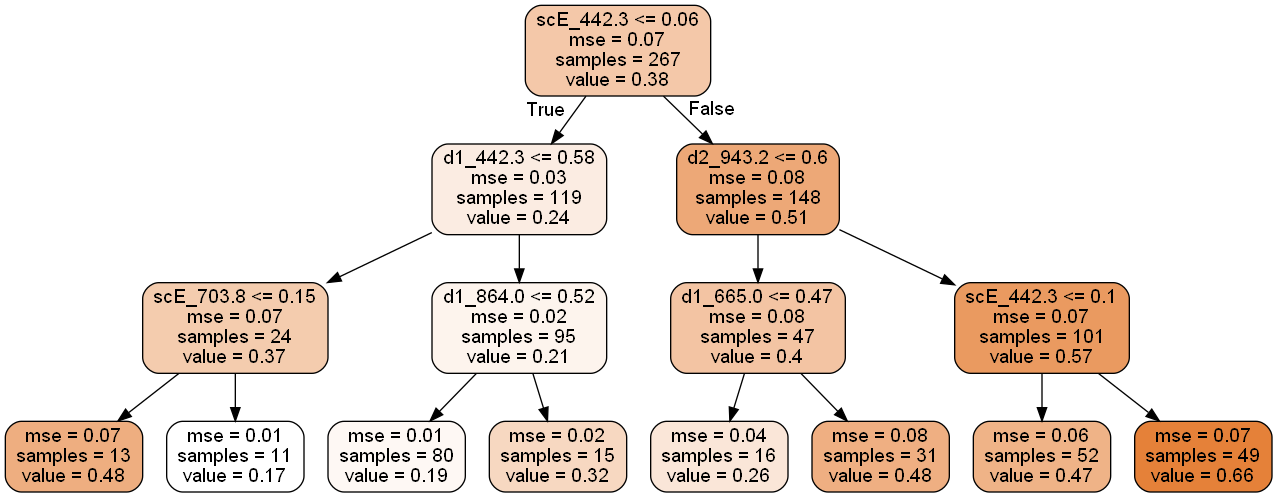

In [61]:
from IPython.display import Image
Image(filename = 'somefile.png')